# Getting tensorflow-serving working on eagle

First, built a tensorflow-serving docker container in /projects/rlmolecule/pstjohn/containers with
```bash
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg docker://tensorflow/serving
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving-gpu.simg docker://tensorflow/serving:latest-gpu
```

*NOTE:* I apparently didn't build a GPU-capable image; that will probably have to happen following these instructions https://www.tensorflow.org/tfx/serving/docker#running_a_gpu_serving_image

In [1]:
# Be a good citizen when running this on a shared DAV node
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
import nfp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load up the data we'll be fitting, in this case Yield Sooting Index (10.1016/j.combustflame.2017.12.005)
import pandas as pd
data = pd.read_csv('ysi.csv', index_col=0)
data.head()

,Species,YSI,SMILES,CAS,Formula,Ref,Type,YSI_err
0,2-~{tert}-butylfuran,107.5,CC(C)(C)c1ccco1,NaN,NaN,NaN,NaN,5.375
1,hex-2-yne,66.9,CC#CCCC,764-35-2,NaN,NaN,NaN,3.345
2,hept-2-yne,75.2,CC#CCCCC,1119-65-9,NaN,NaN,NaN,3.760
3,oct-2-yne,81.2,CC#CCCCCC,2809-67-8,NaN,NaN,NaN,4.060
4,"2,6,10-trimethyldodecane",109.8,CCC(C)CCCC(C)CCCC(C)C,3891-98-3,NaN,NaN,NaN,5.490


In [3]:
train = data.sample(frac=.8)
valid = data[~data.index.isin(train)]

Load NFP and construct the tensorflow inputs

In [4]:
import nfp
from tensorflow.keras import layers
from layers import NodeUpdate, EdgeUpdate, GlobalSumPooling1D

preprocessor = nfp.SmilesPreprocessor()

train_inputs = [preprocessor.construct_feature_matrices(smiles, train=True) for smiles in train.SMILES]
valid_inputs = [preprocessor.construct_feature_matrices(smiles, train=False) for smiles in valid.SMILES]

def create_dataset(inputs, targets):
    """ This process is still a bit of a pain. This does the padded batch operation
    for the above inputs to handle batching and variable-sized molecules """
    return tf.data.Dataset.from_generator(
        lambda: ((x, t) for x, t in zip(inputs, targets)),
        output_types=(preprocessor.output_types, tf.float32),
        output_shapes=(preprocessor.output_shapes, []))\
        .padded_batch(batch_size=16, 
                      padded_shapes=(preprocessor.padded_shapes(), []),
                      padding_values=(preprocessor.padding_values, 0.))\
        .prefetch(tf.data.experimental.AUTOTUNE)    


train_dataset = create_dataset(train_inputs, train.YSI).shuffle(500)
valid_dataset = create_dataset(valid_inputs, valid.YSI)

Specify and train a fairly simple GNN

In [79]:
atom_class = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond_class = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

# Initialize the atom states
atom_state = layers.Embedding(preprocessor.atom_classes, 16,
                              name='atom_embedding', mask_zero=True)(atom_class)

# This serves as a bias
atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom_class)

# Initialize the bond states
bond_state = layers.Embedding(preprocessor.bond_classes, 16,
                              name='bond_embedding', mask_zero=True)(bond_class)

for _ in range(3):
    bond_state = EdgeUpdate()([atom_state, bond_state, connectivity])
    atom_state = NodeUpdate()([atom_state, bond_state, connectivity])
    
out = layers.Dense(1)(atom_state)
out = layers.Add()([out, atom_mean])
out = GlobalSumPooling1D()(out)

model = tf.keras.Model([atom_class, bond_class, connectivity], out)
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam(1E-3))
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
atom_embedding (Embedding)      (None, None, 16)     288         atom[0][0]                       
__________________________________________________________________________________________________
bond_embedding (Embedding)      (None, None, 16)     624         bond[0][0]                       
___________________________________________________________________________________________

In [80]:
# model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50
29/29 - 1s - loss: 3.4942 - val_loss: 1.2878
Epoch 2/50
29/29 - 1s - loss: 1.0596 - val_loss: 0.8795
Epoch 3/50
29/29 - 1s - loss: 0.7246 - val_loss: 0.5038
Epoch 4/50
29/29 - 0s - loss: 0.3275 - val_loss: 0.1967
Epoch 5/50
29/29 - 0s - loss: 0.1843 - val_loss: 0.1638
Epoch 6/50
29/29 - 0s - loss: 0.1584 - val_loss: 0.1439
Epoch 7/50
29/29 - 0s - loss: 0.1472 - val_loss: 0.1391
Epoch 8/50
29/29 - 0s - loss: 0.1403 - val_loss: 0.1284
Epoch 9/50
29/29 - 0s - loss: 0.1304 - val_loss: 0.1237
Epoch 10/50
29/29 - 0s - loss: 0.1240 - val_loss: 0.1168
Epoch 11/50
29/29 - 0s - loss: 0.1187 - val_loss: 0.1128
Epoch 12/50
29/29 - 0s - loss: 0.1125 - val_loss: 0.1070
Epoch 13/50
29/29 - 0s - loss: 0.1087 - val_loss: 0.1052
Epoch 14/50
29/29 - 0s - loss: 0.1064 - val_loss: 0.1085
Epoch 15/50
29/29 - 1s - loss: 0.0974 - val_loss: 0.0880
Epoch 16/50
29/29 - 0s - loss: 0.0881 - val_loss: 0.0861
Epoch 17/50
29/29 - 0s - loss: 0.0866 - val_loss: 0.0841
Epoch 18/50
29/29 - 0s - loss: 0.0754 - 

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

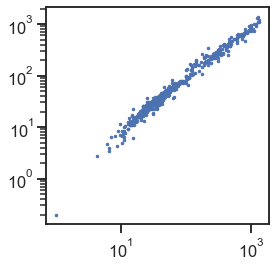

In [88]:
plt.figure(figsize=(4,4))
plt.loglog(valid.YSI, model.predict(valid_dataset), '.', ms=5)

In [99]:
# Following https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = 'ysi_model'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = ysi_model/1

INFO:tensorflow:Assets written to: ysi_model/1/assets


### Running tensorflow serving

run_tf_serving.sh launches the tensorflow serving container with
```bash
SINGULARITYENV_MODEL_NAME=ysi_model singularity exec -B ./ysi_model:/models/ysi_model /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg tf_serving_entrypoint.sh
```

In [36]:
# Here's how we prepare the data on the worker nodes and serialize it to a json

import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def trim_input(inputs, pad=True):
    """ The default SmilesPreprocessor returns some extra info we dont
    use in the simple model above, so we have to strip it down """
    data_dict = {key: val for key, val in inputs.items() 
                 if key in ['atom', 'bond', 'connectivity']}
    
    if pad:
        data_dict['atom'] = np.hstack([0, data_dict['atom']])
        data_dict['bond'] = np.hstack([0, data_dict['bond']])
        data_dict['connectivity'] = \
            np.vstack([np.array([0, 0]), data_dict['connectivity'] + 1])
        return data_dict        
 
    else:
        return data_dict

In [39]:
# We use requests to ping the TF serving model and get a response

import requests

test_input = trim_input(train_inputs[0], pad=False)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

predictions

[[75.5210114]]

In [40]:
test_input = trim_input(train_inputs[0], pad=True)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

predictions

[[75.5210114]]

In [42]:
train.iloc[0]

Species    2,2,4,4-tetramethyl-3-pentanone imine
YSI                                      62.2986
SMILES                     CC(C)(C)C(=N)C(C)(C)C
CAS                                   29097-52-7
Formula                                   C9H19N
Ref                                          NaN
Type                                         NaN
YSI_err                                  3.11493
Name: 99, dtype: object

In [149]:
# Validate it's the same prediction we get from the local model
model({key: numpy.expand_dims(val, 0) for key, val in 
       test_input.items()})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[30.14687]], dtype=float32)>

Great!, So, still todo:

1) make sure this can work on a GPU (note, the singularity call changes slightly to expose the GPU binaries... I hope this works on Eagle. I've played around a bit with this, but I can't remember if it worked)

2) Correctly configure the batching behavior on the TF serving side

3) Verify that calling and waiting for the GPU result is actually faster than just evaluating on the worker CPUs :). This would require a production-scale model though